In [1]:
# Imports
import geopandas as gpd
import pandas as pd
import hvplot.pandas
import os
import pathlib
import xarray as xr
import glob
import rioxarray as rxr
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box

In [2]:
BASE_DATA_PATH = pathlib.Path.cwd().parent / "data"
BASE_NDVI_PATH = BASE_DATA_PATH / "NDVI"
BASE_TEMP_PATH = BASE_DATA_PATH / "Temperature"
print(BASE_DATA_PATH)

/home/keingtobin/School/GEOG3301/hayman-analysis/data


## Start Wrangling the Data

First thing, lets get the shapefile imported.

<Axes: >

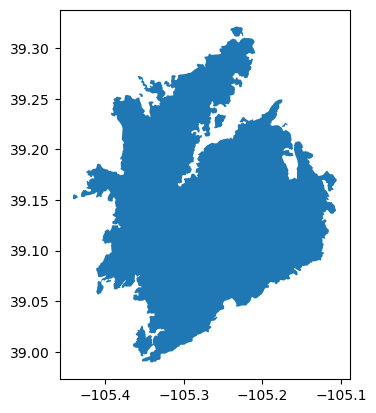

In [3]:
# Define our path
hayman_bound_path = BASE_DATA_PATH / "Hayman_MTBS_Datapackage/co3922010528720020608_20010824_20030814_burn_bndy.shp"
hayman_bounds_gdf = gpd.read_file(hayman_bound_path).to_crs(crs="EPSG:4326")
hayman_bounds_gdf.plot()

<Axes: >

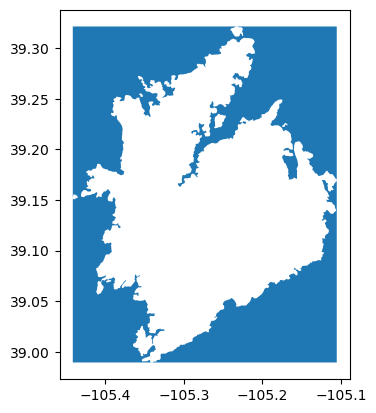

In [4]:
# Grab a box surrounding the area, with the area cut out.
bbox = box(*hayman_bounds_gdf.total_bounds)
outside_hayman_bounds = gpd.GeoDataFrame(geometry=[bbox], crs=hayman_bounds_gdf.crs).overlay(hayman_bounds_gdf, how = "difference")
outside_hayman_bounds.plot()

Now we need to try and get all of our NDVI data imported.

In [12]:
NDVI_BASE_PATH = BASE_DATA_PATH / "NDVI"
years = os.listdir(NDVI_BASE_PATH)
min_lat = 38
max_lat = 39
min_lon = -104.5
max_lon = -105.5
#ndvi_years = []
#for year in years:
#    path = str(NDVI_BASE_PATH / year / "*.nc")
#    ds = xarray.open_mfdataset(path)
#    tup = (year,ds)
#    ndvi_years.append(tup)

#test_ds = test_ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(max_lon,min_lon))
#test_df = test_ds['NDVI'].to_dataframe().reset_index()
#gdf = gpd.GeoDataFrame(
#    test_df,
#    geometry=gpd.points_from_xy(test_df.longitude, test_df.latitude, crs="EPSG:4326")
#)

ndvi_years = []
for year in years:
    path = str(NDVI_BASE_PATH / year / "*.nc")
    ds = xarray.open_mfdataset(path)
    ds = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(max_lon,min_lon))
    df = ds['NDVI'].to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:2232")
    )
    joined_gdf = (
        hayman_bounds_gdf
        .to_crs(gdf.crs)
        .sjoin(
            gdf,
            how="inner",
            predicate="contains"
        )
    )
    
    tup = (year,joined_gdf)
    ndvi_years.append(tup)


/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xarray.open_mfdataset(path)
/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xarray.open_mfdataset(path)
/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of

In [16]:
NDVI_BASE_PATH = BASE_DATA_PATH / "NDVI"
data = xarray.open_mfdataset(str(NDVI_BASE_PATH / "2002" /  "*.nc"), data_vars='all')
data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
data = data.rio.write_crs("epsg:2232", inplace=True)


In [18]:
print(data.dims)
print(data.coords)

FrozenMappingWarningOnValuesAccess({'time': 31, 'latitude': 3600, 'nv': 2, 'longitude': 7200})
Coordinates:
    crs        int64 8B 0
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 248B 2002-07-01 2002-07-02 ... 2002-07-31


In [17]:
clipped = data.rio.clip(hayman_bounds_gdf.geometry, hayman_bounds_gdf.crs, drop=True)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: lat_bnds

In [12]:
## Try with just one dataset
file = BASE_DATA_PATH / "NDVI" / "2001" / "AVHRR-Land_v005_AVH13C1_NOAA-16_20010701_c20170608114619.nc"
data = xarray.open_dataset(file)
data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
data = data.rio.write_crs("EPSG:4326", inplace=False)
data = data["NDVI"]

In [13]:
print(data)

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)> Size: 207MB
[25920000 values with dtype=float64]
Coordinates:
    crs        int64 8B 0
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 8B 2001-07-01
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    standard_name:  normalized_difference_vegetation_index


In [14]:
clipped = data.rio.clip(hayman_bounds_gdf.geometry, hayman_bounds_gdf.crs, drop=True)


In [26]:
clipped[0]

<xarray.DataArray 'NDVI' (latitude: 6, longitude: 6)> Size: 288B
array([[   nan,    nan, 0.0557, 0.0808,    nan,    nan],
       [0.0529, 0.008 , 0.026 , 0.0388,    nan,    nan],
       [0.0457, 0.049 , 0.0337, 0.0346,    nan,    nan],
       [0.1607, 0.091 , 0.0682, 0.0618, 0.0603, 0.0599],
       [0.1979, 0.1558, 0.0546, 0.0358, 0.0547,    nan],
       [   nan, 0.149 , 0.0796,    nan,    nan,    nan]])
Coordinates:
  * latitude     (latitude) float32 24B 39.27 39.22 39.17 39.12 39.07 39.02
  * longitude    (longitude) float32 24B -105.4 -105.3 -105.3 ... -105.2 -105.1
    time         datetime64[ns] 8B 2001-07-01
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    standard_name:  normalized_difference_vegetation_index

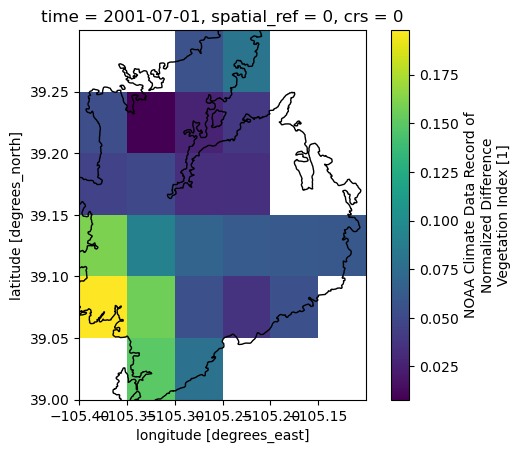

In [29]:
ax=hayman_bounds_gdf.plot(facecolor='none',edgecolor='black')
plot=clipped[0].plot(ax=ax,zorder=-1)
#plt.savefig('Pakistan.png',dpi=300)

In [20]:
test_temp_path = BASE_TEMP_PATH / "MOD11A1.A2001210.h09v05.061.2020096190656.hdf"
test_temp = rxr.open_rasterio(test_temp_path, masked=True).squeeze()
type(test_temp)

xarray.core.dataset.Dataset

In [19]:
test_temp

<xarray.Dataset> Size: 23MB
Dimensions:          (x: 1200, y: 1200)
Coordinates:
    band             int64 8B 1
  * x                (x) float64 10kB -1.001e+07 -1.001e+07 ... -8.896e+06
  * y                (y) float64 10kB 4.447e+06 4.446e+06 ... 3.336e+06
    spatial_ref      int64 8B 0
Data variables:
    LST_Day_1km      (y, x) uint16 3MB ...
    Emis_32          (y, x) uint8 1MB ...
    Clear_day_cov    (y, x) uint16 3MB ...
    Clear_night_cov  (y, x) uint16 3MB ...
    QC_Day           (y, x) uint8 1MB ...
    Day_view_time    (y, x) uint8 1MB ...
    Day_view_angl    (y, x) uint8 1MB ...
    LST_Night_1km    (y, x) uint16 3MB ...
    QC_Night         (y, x) uint8 1MB ...
    Night_view_time  (y, x) uint8 1MB ...
    Night_view_angl  (y, x) uint8 1MB ...
    Emis_31          (y, x) uint8 1MB ...
Attributes: (12/97)
    ALGORITHMPACKAGEACCEPTANCEDATE:     102004
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR11A
    ALGORITHMPACKAGEVERSION:            6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            30.0041666666667
    SPSOPARAMETERS:                     2484 and 3323
    TileID:                             51009005
    VERSIONID:                          61
    VERTICALTILENUMBER:                 5
    WESTBOUNDINGCOORDINATE:             -117.492086386791

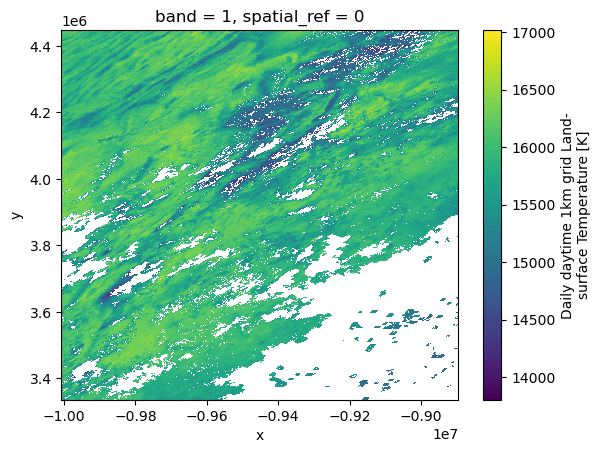

In [21]:
test_temp['LST_Day_1km'].plot()

In [7]:
temp_clip = test_temp.rio.clip(outside_hayman_bounds.geometry.apply(mapping),
                              crs=hayman_bounds_gdf.crs,
                              all_touched=True,
                              from_disk=True)

new_temp_clip = temp_clip['LST_Day_1km']

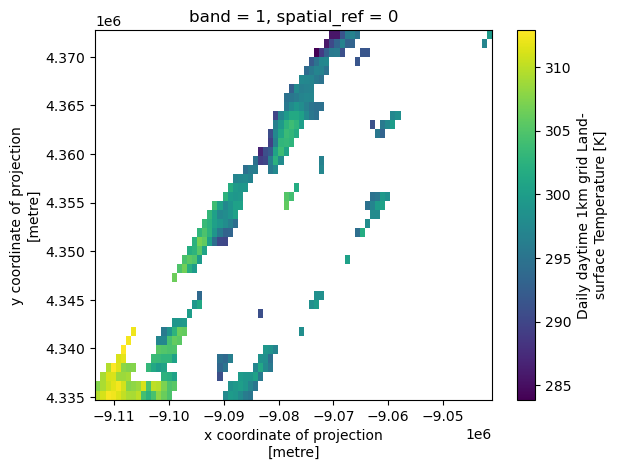

In [8]:
new_temp_clip.plot()